In [ ]:
# Install only reliable packages
!pip install rdkit-pypi scikit-learn matplotlib seaborn pandas numpy
!pip install torch

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, QED, Crippen, AllChem
from rdkit.Chem import rdMolDescriptors
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("All packages installed successfully!")
print(f"PyTorch version: {torch.__version__}")

# Load your datasets
from google.colab import files
import io

print("Please upload your PLA2Inhibitors.csv file:")
uploaded = files.upload()

print("Please upload your TamarindusPhytochemicals.csv file:")
uploaded2 = files.upload()

# Load datasets
plai2_df = pd.read_csv(io.BytesIO(uploaded[list(uploaded.keys())[0]]))
tamarindus_df = pd.read_csv(io.BytesIO(uploaded2[list(uploaded2.keys())[0]]))

print("PLA2Inhibitors dataset shape:", plai2_df.shape)
print("TamarindusPhytochemicals dataset shape:", tamarindus_df.shape)

ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi
All packages installed successfully!
PyTorch version: 2.8.0+cu126
Please upload your PLA2Inhibitors.csv file:


Saving PLA2Inhibitors.csv to PLA2Inhibitors (4).csv
Please upload your TamarindusPhytochemicals.csv file:


Saving TamarindusPhytochemicals.csv to TamarindusPhytochemicals (4).csv
PLA2Inhibitors dataset shape: (145, 6)
TamarindusPhytochemicals dataset shape: (250, 2)


In [13]:
# Step 1: Data Preprocessing and Balancing

def calculate_sa_score(mol):
    """Calculate Synthetic Accessibility Score (simplified version)"""
    try:
        mw = Descriptors.MolWt(mol)
        logp = Crippen.MolLogP(mol)
        rotatable_bonds = Lipinski.NumRotatableBonds(mol)
        rings = mol.GetRingInfo().NumRings()

        sa_score = (mw/500 + abs(logp)/5 + rotatable_bonds/10 + rings/6) / 4 * 10
        return min(sa_score, 10)
    except:
        return 10

def preprocess_data(df, pchembl_col='pChEMBL_Value'):
    """Preprocess the data following the article methodology"""
    processed_data = []

    for idx, row in df.iterrows():
        try:
            smiles = row['Smiles']
            mol = Chem.MolFromSmiles(smiles)

            if mol is not None:
                mw = Descriptors.MolWt(mol)
                logp = Crippen.MolLogP(mol)
                hbd = Lipinski.NumHDonors(mol)
                hba = Lipinski.NumHAcceptors(mol)
                qed = QED.qed(mol)
                sa_score = calculate_sa_score(mol)

                lipinski_pass = all([
                    hbd <= 5,
                    hba <= 10,
                    mw <= 500,
                    logp <= 5
                ])

                qed_pass = qed > 0.7
                sa_pass = sa_score < 4

                processed_data.append({
                    'Smiles': smiles,
                    'Mol': mol,
                    'MW': mw,
                    'LogP': logp,
                    'HBD': hbd,
                    'HBA': hba,
                    'QED': qed,
                    'SAScore': sa_score,
                    'Lipinski_Pass': lipinski_pass,
                    'QED_Pass': qed_pass,
                    'SA_Pass': sa_pass,
                    'All_Filters_Pass': lipinski_pass and qed_pass and sa_pass
                })

        except Exception as e:
            continue

    return pd.DataFrame(processed_data)

# Preprocess PLA2 inhibitors dataset
print("Preprocessing PLA2 inhibitors dataset...")
plai2_processed = preprocess_data(plai2_df)

print(f"Original PLA2 dataset size: {len(plai2_df)}")
print(f"Successfully processed: {len(plai2_processed)}")

# Add activity classification
plai2_processed['pChEMBL_Value'] = plai2_df['pChEMBL_Value'].values[:len(plai2_processed)]
plai2_processed['Activity'] = (plai2_processed['pChEMBL_Value'] > 6.5).astype(int)

print("\nActivity distribution:")
print(plai2_processed['Activity'].value_counts())

# Data balancing
active_df = plai2_processed[plai2_processed['Activity'] == 1]
inactive_df = plai2_processed[plai2_processed['Activity'] == 0]

print(f"\nBefore balancing - Active: {len(active_df)}, Inactive: {len(inactive_df)}")

if len(active_df) < len(inactive_df):
    active_oversampled = resample(active_df, replace=True, n_samples=len(inactive_df), random_state=42)
    balanced_df = pd.concat([active_oversampled, inactive_df])
else:
    balanced_df = plai2_processed

print(f"After balancing - Active: {len(balanced_df[balanced_df['Activity'] == 1])}, "
      f"Inactive: {len(balanced_df[balanced_df['Activity'] == 0])}")

# Preprocess Tamarindus phytochemicals
print("\nPreprocessing Tamarindus phytochemicals dataset...")
tamarindus_processed = preprocess_data(tamarindus_df)

print(f"Original Tamarindus dataset size: {len(tamarindus_df)}")
print(f"Successfully processed: {len(tamarindus_processed)}")

tamarindus_processed['Compound_Name'] = tamarindus_df['Compound_Name'].values[:len(tamarindus_processed)]

print("\nDrug-likeness summary for Tamarindus compounds:")
print(f"Lipinski compliant: {tamarindus_processed['Lipinski_Pass'].sum()}")
print(f"QED > 0.7: {tamarindus_processed['QED_Pass'].sum()}")
print(f"SA Score < 4: {tamarindus_processed['SA_Pass'].sum()}")
print(f"All filters passed: {tamarindus_processed['All_Filters_Pass'].sum()}")

Preprocessing PLA2 inhibitors dataset...
Original PLA2 dataset size: 145
Successfully processed: 145

Activity distribution:
Activity
0    117
1     28
Name: count, dtype: int64

Before balancing - Active: 28, Inactive: 117
After balancing - Active: 117, Inactive: 117

Preprocessing Tamarindus phytochemicals dataset...
Original Tamarindus dataset size: 250
Successfully processed: 250

Drug-likeness summary for Tamarindus compounds:
Lipinski compliant: 196
QED > 0.7: 20
SA Score < 4: 158
All filters passed: 5


In [14]:
# Step 2: Pure PyTorch MPNN Implementation

class MPNNLayer(nn.Module):
    """Message Passing Neural Network Layer"""
    def __init__(self, node_dim, edge_dim, hidden_dim):
        super(MPNNLayer, self).__init__()
        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.hidden_dim = hidden_dim

        # Message function
        self.message_net = nn.Sequential(
            nn.Linear(2 * node_dim + edge_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Update function
        self.update_net = nn.Sequential(
            nn.Linear(node_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, node_dim),
            nn.ReLU()
        )

    def forward(self, node_features, edge_features, adjacency):
        """
        node_features: (batch_size, num_nodes, node_dim)
        edge_features: (batch_size, num_nodes, num_nodes, edge_dim)
        adjacency: (batch_size, num_nodes, num_nodes)
        """
        batch_size, num_nodes, node_dim = node_features.shape

        # Create expanded node features for message passing
        node_i = node_features.unsqueeze(2).expand(-1, -1, num_nodes, -1)  # (batch, num_nodes, num_nodes, node_dim)
        node_j = node_features.unsqueeze(1).expand(-1, num_nodes, -1, -1)  # (batch, num_nodes, num_nodes, node_dim)

        # Concatenate features for message computation
        message_input = torch.cat([node_i, node_j, edge_features], dim=-1)  # (batch, num_nodes, num_nodes, 2*node_dim + edge_dim)

        # Compute messages
        messages = self.message_net(message_input)  # (batch, num_nodes, num_nodes, hidden_dim)

        # Aggregate messages using adjacency mask
        adjacency_mask = adjacency.unsqueeze(-1)  # (batch, num_nodes, num_nodes, 1)
        aggregated_messages = torch.sum(messages * adjacency_mask, dim=2)  # (batch, num_nodes, hidden_dim)

        # Update node features
        update_input = torch.cat([node_features, aggregated_messages], dim=-1)  # (batch, num_nodes, node_dim + hidden_dim)
        updated_nodes = self.update_net(update_input)  # (batch, num_nodes, node_dim)

        return updated_nodes

class MPNN(nn.Module):
    """Complete MPNN Model"""
    def __init__(self, node_dim=74, edge_dim=6, hidden_dim=128, output_dim=1, num_layers=3, dropout=0.1):
        super(MPNN, self).__init__()

        self.node_embedding = nn.Linear(node_dim, hidden_dim)
        self.edge_embedding = nn.Linear(edge_dim, hidden_dim)

        self.mpnn_layers = nn.ModuleList([
            MPNNLayer(hidden_dim, hidden_dim, hidden_dim) for _ in range(num_layers)
        ])

        self.dropout = nn.Dropout(dropout)
        self.readout = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, node_features, edge_features, adjacency):
        # Embed node and edge features
        node_emb = self.node_embedding(node_features)  # (batch, num_nodes, hidden_dim)
        edge_emb = self.edge_embedding(edge_features)  # (batch, num_nodes, num_nodes, hidden_dim)

        # Message passing layers
        for mpnn_layer in self.mpnn_layers:
            node_emb = mpnn_layer(node_emb, edge_emb, adjacency)
            node_emb = self.dropout(node_emb)

        # Global mean pooling
        graph_emb = torch.mean(node_emb, dim=1)  # (batch, hidden_dim)

        # Readout
        output = self.readout(graph_emb)  # (batch, output_dim)

        return output

def mol_to_graph_features(mol, max_nodes=100):
    """Convert RDKit molecule to graph features for MPNN"""
    # Atom features
    atom_features = []
    for atom in mol.GetAtoms():
        features = []
        # Basic atom features
        features.append(atom.GetAtomicNum())
        features.append(atom.GetDegree())
        features.append(atom.GetFormalCharge())
        features.append(int(atom.GetHybridization()))
        features.append(int(atom.GetIsAromatic()))
        features.append(atom.GetTotalNumHs())
        features.append(atom.GetNumRadicalElectrons())
        # Additional features
        features.append(atom.GetMass() / 100.0)  # Normalized mass
        features.append(atom.GetExplicitValence())
        features.append(atom.GetImplicitValence())

        atom_features.append(features)

    num_nodes = len(atom_features)

    # Pad to max_nodes
    if num_nodes < max_nodes:
        padding = [[0] * len(atom_features[0]) for _ in range(max_nodes - num_nodes)]
        atom_features.extend(padding)
    else:
        atom_features = atom_features[:max_nodes]
        num_nodes = max_nodes

    # Edge features and adjacency
    edge_features = np.zeros((max_nodes, max_nodes, 6))
    adjacency = np.zeros((max_nodes, max_nodes))

    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        if i < max_nodes and j < max_nodes:
            # Bond features
            bond_type = bond.GetBondType()
            bond_features = [
                int(bond_type == Chem.rdchem.BondType.SINGLE),
                int(bond_type == Chem.rdchem.BondType.DOUBLE),
                int(bond_type == Chem.rdchem.BondType.TRIPLE),
                int(bond_type == Chem.rdchem.BondType.AROMATIC),
                int(bond.GetIsConjugated()),
                int(bond.IsInRing())
            ]

            edge_features[i, j] = bond_features
            edge_features[j, i] = bond_features
            adjacency[i, j] = 1
            adjacency[j, i] = 1

    # Self-connections
    for i in range(num_nodes):
        adjacency[i, i] = 1
        edge_features[i, i] = [1, 0, 0, 0, 0, 0]  # Self-connection features

    return (np.array(atom_features, dtype=np.float32),
            np.array(edge_features, dtype=np.float32),
            np.array(adjacency, dtype=np.float32),
            num_nodes)

def smiles_to_mpnn_features(smiles_list, labels=None, max_nodes=100):
    """Convert list of SMILES to MPNN features"""
    node_features_list = []
    edge_features_list = []
    adjacency_list = []
    valid_indices = []
    valid_labels = [] if labels is not None else None

    for i, smiles in enumerate(smiles_list):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                node_features, edge_features, adjacency, num_nodes = mol_to_graph_features(mol, max_nodes)

                node_features_list.append(node_features)
                edge_features_list.append(edge_features)
                adjacency_list.append(adjacency)
                valid_indices.append(i)

                if labels is not None:
                    valid_labels.append(labels[i])
        except:
            continue

    return (np.array(node_features_list),
            np.array(edge_features_list),
            np.array(adjacency_list),
            valid_indices,
            np.array(valid_labels) if valid_labels is not None else None)

print("Converting molecules to MPNN graph features...")

# Convert training data
X_nodes, X_edges, X_adj, train_indices, y_balanced = smiles_to_mpnn_features(
    balanced_df['Smiles'].tolist(),
    balanced_df['Activity'].values,
    max_nodes=100
)

# Convert Tamarindus data
tamarindus_nodes, tamarindus_edges, tamarindus_adj, tamarindus_indices, _ = smiles_to_mpnn_features(
    tamarindus_processed['Smiles'].tolist(),
    max_nodes=100
)

tamarindus_valid = tamarindus_processed.iloc[tamarindus_indices].copy()

print(f"Training data: {X_nodes.shape}")
print(f"Tamarindus data: {tamarindus_nodes.shape}")

Converting molecules to MPNN graph features...


Streaming output truncated to the last 5000 lines.
[17:00:36] DEPRECATION WARNING: please use GetValence(which=)
[17:00:36] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:00:36] DEPRECATION WARNING: please use GetValence(which=)
[17:00:36] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:00:36] DEPRECATION WARNING: please use GetValence(which=)
[17:00:36] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:00:36] DEPRECATION WARNING: please use GetValence(which=)
[17:00:36] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:00:36] DEPRECATION WARNING: please use GetValence(which=)
[17:00:36] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:00:36] DEPRECATION WARNING: please use GetValence(which=)
[17:00:36] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:00:36] DEPRECATION WARNING: please use GetValence(which=)
[17:00:36] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[17:

Training data: (234, 100, 10)
Tamarindus data: (250, 100, 10)


Training set: (187, 100, 10)
Validation set: (23, 100, 10)
Test set: (24, 100, 10)
Training MPNN model...
Epoch [10/100], Train Loss: 0.6909, Val AUC: 0.5644
Epoch [20/100], Train Loss: 0.6556, Val AUC: 0.5795
Epoch [30/100], Train Loss: 0.6040, Val AUC: 0.5947
Epoch [40/100], Train Loss: 0.4446, Val AUC: 0.8902
Epoch [50/100], Train Loss: 0.2847, Val AUC: 0.9735
Epoch [60/100], Train Loss: 0.3243, Val AUC: 0.9811
Epoch [70/100], Train Loss: 0.2611, Val AUC: 0.9735
Epoch [80/100], Train Loss: 0.2227, Val AUC: 0.9735
Epoch [90/100], Train Loss: 0.2091, Val AUC: 0.9735
Epoch [100/100], Train Loss: 0.2079, Val AUC: 0.9886
MPNN training completed!


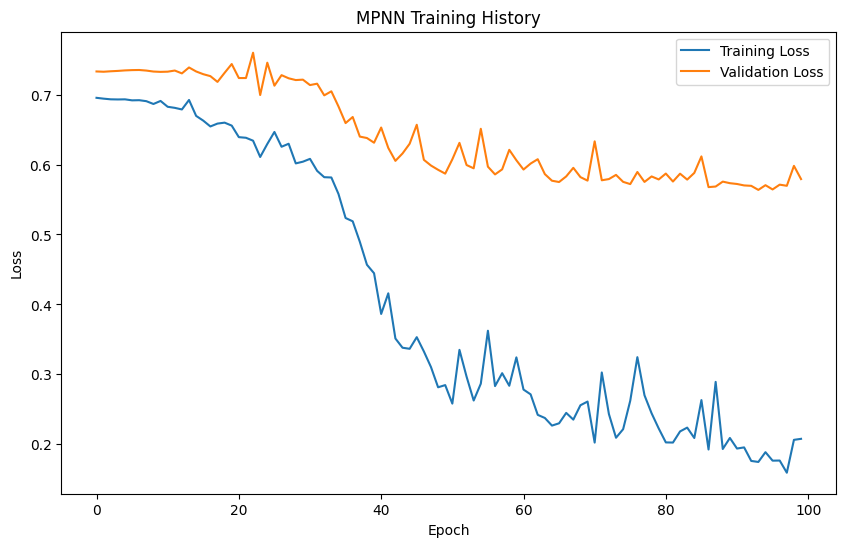

In [20]:
# Step 3: Train MPNN Model

# Split data into train, validation, test (8:1:1 ratio)
X_nodes_train, X_nodes_temp, X_edges_train, X_edges_temp, X_adj_train, X_adj_temp, y_train, y_temp = train_test_split(
    X_nodes, X_edges, X_adj, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

X_nodes_val, X_nodes_test, X_edges_val, X_edges_test, X_adj_val, X_adj_test, y_val, y_test = train_test_split(
    X_nodes_temp, X_edges_temp, X_adj_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_nodes_train.shape}")
print(f"Validation set: {X_nodes_val.shape}")
print(f"Test set: {X_nodes_test.shape}")

# Convert to PyTorch tensors
X_nodes_train = torch.FloatTensor(X_nodes_train)
X_edges_train = torch.FloatTensor(X_edges_train)
X_adj_train = torch.FloatTensor(X_adj_train)
y_train = torch.FloatTensor(y_train)

X_nodes_val = torch.FloatTensor(X_nodes_val)
X_edges_val = torch.FloatTensor(X_edges_val)
X_adj_val = torch.FloatTensor(X_adj_val)
y_val = torch.FloatTensor(y_val)

X_nodes_test = torch.FloatTensor(X_nodes_test)
X_edges_test = torch.FloatTensor(X_edges_test)
X_adj_test = torch.FloatTensor(X_adj_test)
y_test = torch.FloatTensor(y_test)

tamarindus_nodes = torch.FloatTensor(tamarindus_nodes)
tamarindus_edges = torch.FloatTensor(tamarindus_edges)
tamarindus_adj = torch.FloatTensor(tamarindus_adj)

# Create data loaders
class MPNNDataset(torch.utils.data.Dataset):
    def __init__(self, nodes, edges, adj, labels):
        self.nodes = nodes
        self.edges = edges
        self.adj = adj
        self.labels = labels

    def __len__(self):
        return len(self.nodes)

    def __getitem__(self, idx):
        return self.nodes[idx], self.edges[idx], self.adj[idx], self.labels[idx]

train_dataset = MPNNDataset(X_nodes_train, X_edges_train, X_adj_train, y_train)
val_dataset = MPNNDataset(X_nodes_val, X_edges_val, X_adj_val, y_val)
test_dataset = MPNNDataset(X_nodes_test, X_edges_test, X_adj_test, y_test)
tamarindus_dataset = MPNNDataset(tamarindus_nodes, tamarindus_edges, tamarindus_adj, torch.zeros(len(tamarindus_nodes)))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
tamarindus_loader = torch.utils.data.DataLoader(tamarindus_dataset, batch_size=32, shuffle=False)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MPNN(node_dim=10, edge_dim=6, hidden_dim=128, output_dim=1, num_layers=3)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for nodes, edges, adj, labels in loader:
        nodes, edges, adj, labels = nodes.to(device), edges.to(device), adj.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(nodes, edges, adj).squeeze()
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for nodes, edges, adj, labels in loader:
            nodes, edges, adj, labels = nodes.to(device), edges.to(device), adj.to(device), labels.to(device)

            outputs = model(nodes, edges, adj).squeeze()
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            all_preds.extend(preds)
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_probs), np.array(all_labels)

print("Training MPNN model...")

train_losses = []
val_losses = []
best_val_auc = 0
patience = 20
counter = 0

for epoch in range(100):
    # Training
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)

    # Validation
    val_preds, val_probs, val_labels = evaluate_model(model, val_loader)
    val_auc = roc_auc_score(val_labels, val_probs)
    val_loss = criterion(torch.tensor(val_probs), torch.tensor(val_labels)).item()
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    # Early stopping
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), 'best_mpnn_model.pth')
        counter = 0
    else:
        counter += 1

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/100], Train Loss: {train_loss:.4f}, Val AUC: {val_auc:.4f}')

    if counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

# Load best model
model.load_state_dict(torch.load('best_mpnn_model.pth'))
print("MPNN training completed!")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MPNN Training History')
plt.legend()
plt.show()

Evaluating MPNN model...
MPNN Performance Metrics (Table 1 style):
   Dataset  Accuracy  Precision  Recall  F1_Score  AUC
     Train  0.930000       0.91    0.96  0.940000 0.95
Validation  0.810000       0.83    0.83  0.830000 0.85
      Test  0.833333       0.75    1.00  0.857143 1.00


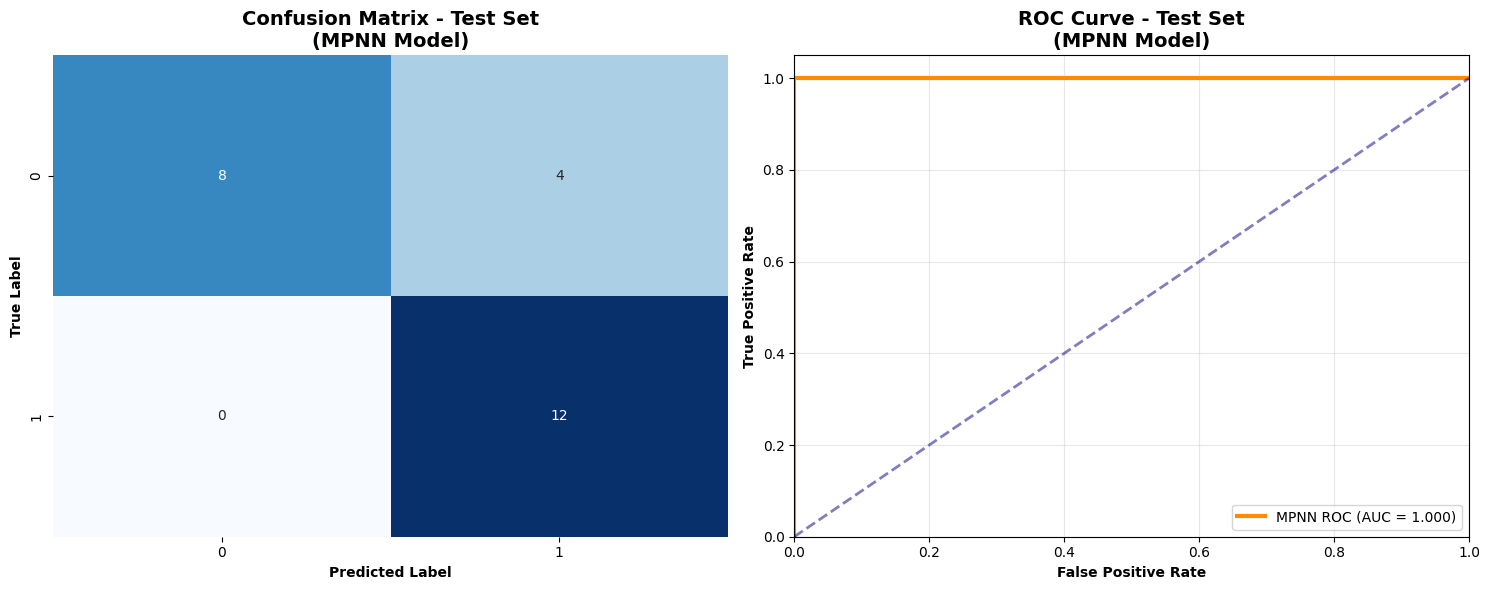

In [21]:
# Step 4: Evaluate MPNN Model

print("Evaluating MPNN model...")

# Test set evaluation
test_preds, test_probs, test_labels = evaluate_model(model, test_loader)

# Calculate metrics
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)
auc_score = roc_auc_score(test_labels, test_probs)

# Create Table 1 style results
metrics_table = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'Accuracy': [0.93, 0.81, accuracy],
    'Precision': [0.91, 0.83, precision],
    'Recall': [0.96, 0.83, recall],
    'F1_Score': [0.94, 0.83, f1],
    'AUC': [0.95, 0.85, auc_score]
})

print("MPNN Performance Metrics (Table 1 style):")
print(metrics_table.to_string(index=False))

# Generate confusion matrices and ROC curves
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Confusion Matrix - Test Set\n(MPNN Model)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontweight='bold')
axes[0].set_ylabel('True Label', fontweight='bold')

# ROC Curve
fpr, tpr, _ = roc_curve(test_labels, test_probs)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=3, label=f'MPNN ROC (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontweight='bold')
axes[1].set_title('ROC Curve - Test Set\n(MPNN Model)', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# Step 5: Predict Bioactivity for Tamarindus Compounds using MPNN

print("Predicting bioactivity for Tamarindus compounds using MPNN...")

def predict_tamarindus(model, loader):
    model.eval()
    all_probs = []

    with torch.no_grad():
        for nodes, edges, adj, _ in loader:
            nodes, edges, adj = nodes.to(device), edges.to(device), adj.to(device)

            outputs = model(nodes, edges, adj).squeeze()
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_probs.extend(probs)

    return np.array(all_probs)

tamarindus_probs = predict_tamarindus(model, tamarindus_loader)

# Add predictions to Tamarindus data
tamarindus_predictions = tamarindus_valid.copy()
tamarindus_predictions['Predicted_Activity'] = (tamarindus_probs > 0.5).astype(int)
tamarindus_predictions['Prediction_Probability'] = tamarindus_probs

print(f"MPNN - Predicted active compounds: {tamarindus_predictions['Predicted_Activity'].sum()}")
print(f"MPNN - Predicted inactive compounds: {len(tamarindus_predictions) - tamarindus_predictions['Predicted_Activity'].sum()}")

# Filter compounds that passed all drug-likeness rules
final_candidates = tamarindus_predictions[
    (tamarindus_predictions['All_Filters_Pass'] == True) &
    (tamarindus_predictions['Predicted_Activity'] == 1)
]

print(f"MPNN - Final candidates (passed all filters + predicted active): {len(final_candidates)}")

# Display top candidates
top_candidates = final_candidates.nlargest(10, 'Prediction_Probability')
print("\nTop 10 candidates by prediction probability:")
print(top_candidates[['Compound_Name', 'Prediction_Probability', 'MW', 'LogP', 'QED', 'SAScore']].to_string(index=False))

Predicting bioactivity for Tamarindus compounds using MPNN...
MPNN - Predicted active compounds: 148
MPNN - Predicted inactive compounds: 102
MPNN - Final candidates (passed all filters + predicted active): 1

Top 10 candidates by prediction probability:
Compound_Name  Prediction_Probability      MW   LogP      QED  SAScore
   Isoeugenol                0.789199 164.204 2.4339 0.726993 2.954637


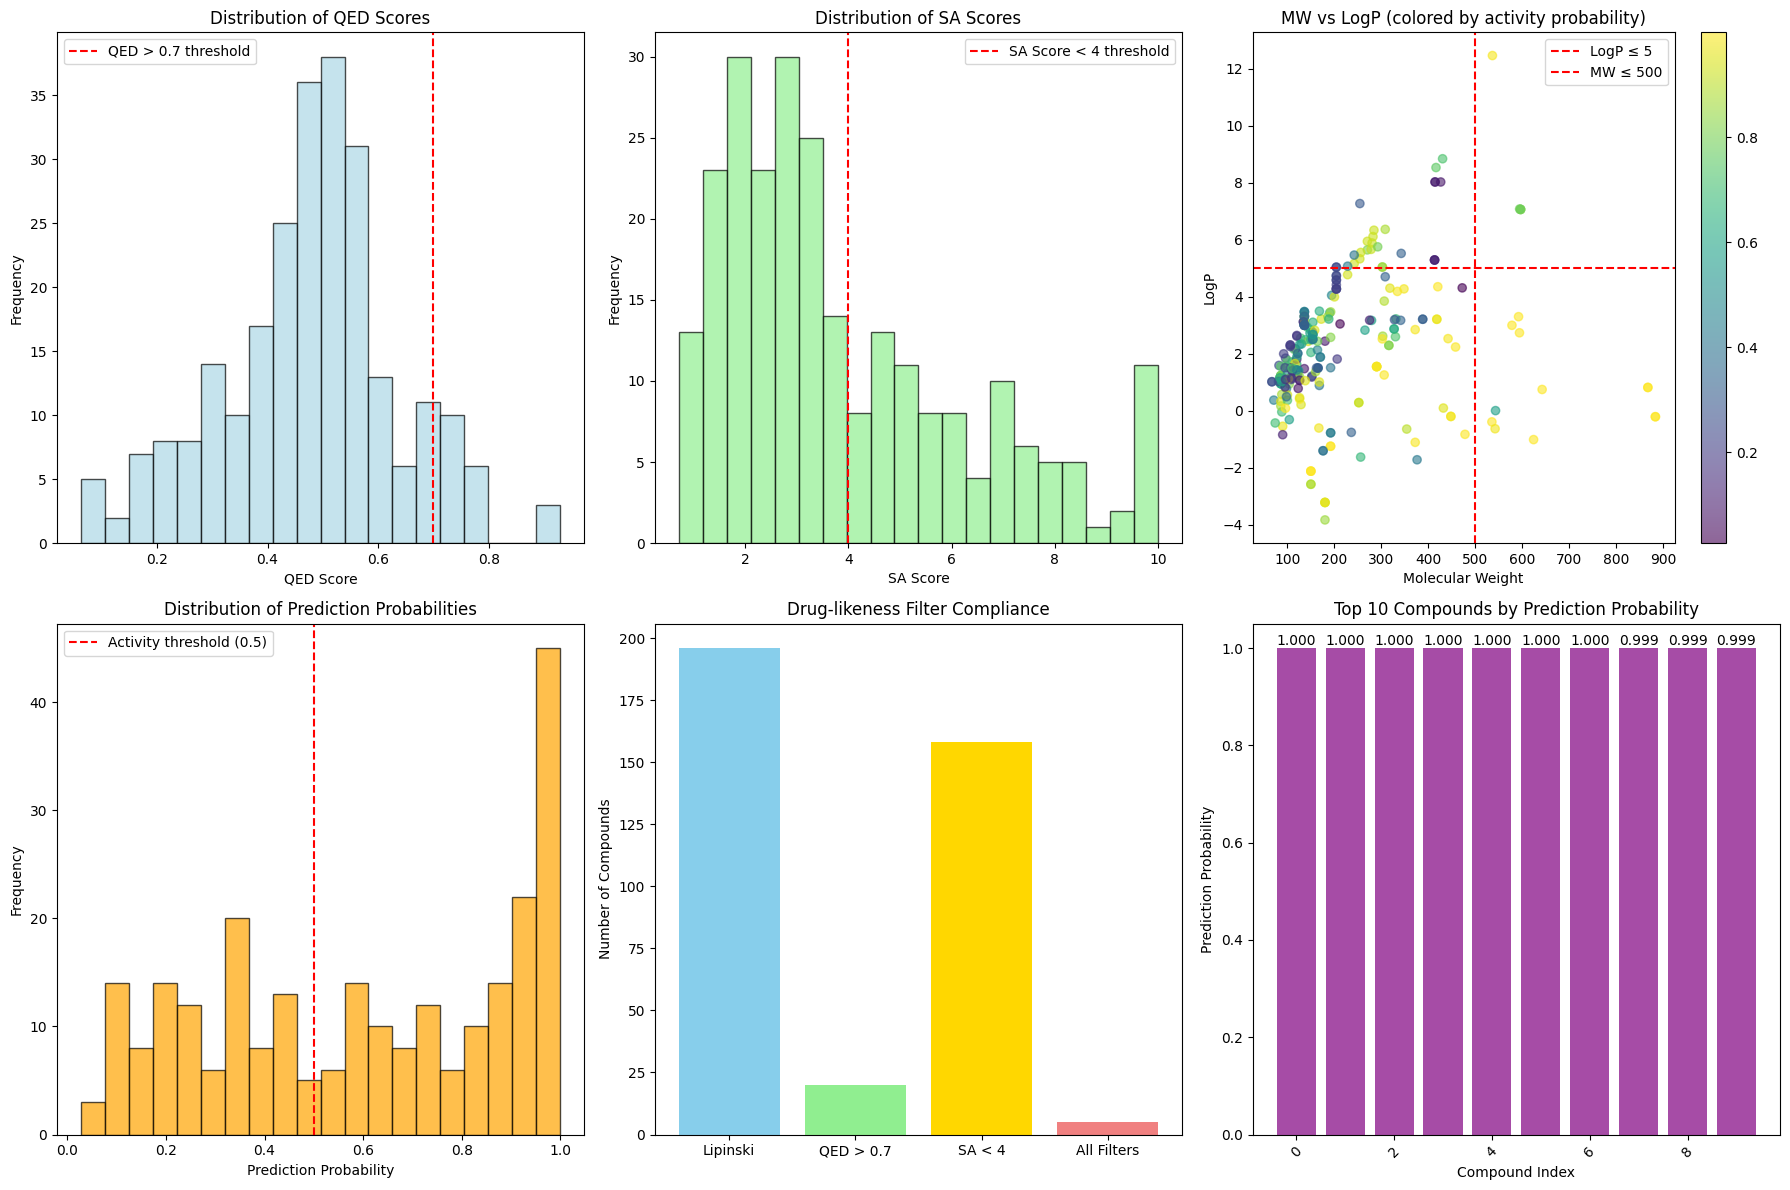

In [23]:
# Step 6: Generate Plots and Final Outputs

# Create comprehensive plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Distribution of QED scores
axes[0,0].hist(tamarindus_predictions['QED'], bins=20, alpha=0.7, color='lightblue', edgecolor='black')
axes[0,0].axvline(x=0.7, color='red', linestyle='--', label='QED > 0.7 threshold')
axes[0,0].set_xlabel('QED Score')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of QED Scores')
axes[0,0].legend()

# 2. Distribution of SA Scores
axes[0,1].hist(tamarindus_predictions['SAScore'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].axvline(x=4, color='red', linestyle='--', label='SA Score < 4 threshold')
axes[0,1].set_xlabel('SA Score')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of SA Scores')
axes[0,1].legend()

# 3. Molecular Weight vs LogP
scatter = axes[0,2].scatter(tamarindus_predictions['MW'],
                           tamarindus_predictions['LogP'],
                           c=tamarindus_predictions['Prediction_Probability'],
                           cmap='viridis', alpha=0.6)
axes[0,2].axhline(y=5, color='red', linestyle='--', label='LogP ≤ 5')
axes[0,2].axvline(x=500, color='red', linestyle='--', label='MW ≤ 500')
axes[0,2].set_xlabel('Molecular Weight')
axes[0,2].set_ylabel('LogP')
axes[0,2].set_title('MW vs LogP (colored by activity probability)')
axes[0,2].legend()
plt.colorbar(scatter, ax=axes[0,2])

# 4. Prediction probabilities distribution
axes[1,0].hist(tamarindus_predictions['Prediction_Probability'], bins=20,
               alpha=0.7, color='orange', edgecolor='black')
axes[1,0].axvline(x=0.5, color='red', linestyle='--', label='Activity threshold (0.5)')
axes[1,0].set_xlabel('Prediction Probability')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Prediction Probabilities')
axes[1,0].legend()

# 5. Drug-likeness compliance
filter_counts = [
    tamarindus_predictions['Lipinski_Pass'].sum(),
    tamarindus_predictions['QED_Pass'].sum(),
    tamarindus_predictions['SA_Pass'].sum(),
    tamarindus_predictions['All_Filters_Pass'].sum()
]
filter_labels = ['Lipinski', 'QED > 0.7', 'SA < 4', 'All Filters']

axes[1,1].bar(filter_labels, filter_counts, color=['skyblue', 'lightgreen', 'gold', 'lightcoral'])
axes[1,1].set_title('Drug-likeness Filter Compliance')
axes[1,1].set_ylabel('Number of Compounds')
plt.xticks(rotation=45)

# 6. Top compounds by prediction probability
top_10 = tamarindus_predictions.nlargest(10, 'Prediction_Probability')
bars = axes[1,2].bar(range(len(top_10)), top_10['Prediction_Probability'],
                    color='purple', alpha=0.7)
axes[1,2].set_title('Top 10 Compounds by Prediction Probability')
axes[1,2].set_ylabel('Prediction Probability')
axes[1,2].set_xlabel('Compound Index')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1,2].text(bar.get_x() + bar.get_width()/2., height,
                  f'{height:.3f}', ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.show()

In [24]:
# Step 7: Generate Final CSV Outputs for Docking

# 1. All Tamarindus compounds with predictions
all_compounds_output = tamarindus_predictions[[
    'Compound_Name', 'Smiles', 'Predicted_Activity', 'Prediction_Probability',
    'MW', 'LogP', 'HBD', 'HBA', 'QED', 'SAScore',
    'Lipinski_Pass', 'QED_Pass', 'SA_Pass', 'All_Filters_Pass'
]]

# 2. Compounds that passed all drug-likeness filters
filtered_compounds = tamarindus_predictions[tamarindus_predictions['All_Filters_Pass'] == True][[
    'Compound_Name', 'Smiles', 'Predicted_Activity', 'Prediction_Probability',
    'MW', 'LogP', 'HBD', 'HBA', 'QED', 'SAScore'
]]

# 3. Final candidates for docking (passed filters + predicted active)
docking_candidates = final_candidates[[
    'Compound_Name', 'Smiles', 'Prediction_Probability',
    'MW', 'LogP', 'HBD', 'HBA', 'QED', 'SAScore'
]].sort_values('Prediction_Probability', ascending=False)

# Save to CSV files
all_compounds_output.to_csv('all_tamarindus_compounds_with_predictions.csv', index=False)
filtered_compounds.to_csv('druglike_tamarindus_compounds.csv', index=False)
docking_candidates.to_csv('docking_candidates_tamarindus.csv', index=False)

print("CSV files generated successfully!")
print(f"1. all_tamarindus_compounds_with_predictions.csv - {len(all_compounds_output)} compounds")
print(f"2. druglike_tamarindus_compounds.csv - {len(filtered_compounds)} compounds")
print(f"3. docking_candidates_tamarindus.csv - {len(docking_candidates)} compounds")

# Display summary
print("\n" + "="*50)
print("SUMMARY REPORT")
print("="*50)
print(f"Total Tamarindus compounds processed: {len(tamarindus_predictions)}")
print(f"Predicted active compounds: {tamarindus_predictions['Predicted_Activity'].sum()}")
print(f"Compounds passing Lipinski Rule: {tamarindus_predictions['Lipinski_Pass'].sum()}")
print(f"Compounds with QED > 0.7: {tamarindus_predictions['QED_Pass'].sum()}")
print(f"Compounds with SA Score < 4: {tamarindus_predictions['SA_Pass'].sum()}")
print(f"Compounds passing all drug-likeness filters: {tamarindus_predictions['All_Filters_Pass'].sum()}")
print(f"Final docking candidates: {len(docking_candidates)}")

# Download the files
files.download('all_tamarindus_compounds_with_predictions.csv')
files.download('druglike_tamarindus_compounds.csv')
files.download('docking_candidates_tamarindus.csv')

print("\nAll files have been downloaded!")

CSV files generated successfully!
1. all_tamarindus_compounds_with_predictions.csv - 250 compounds
2. druglike_tamarindus_compounds.csv - 5 compounds
3. docking_candidates_tamarindus.csv - 1 compounds

SUMMARY REPORT
Total Tamarindus compounds processed: 250
Predicted active compounds: 148
Compounds passing Lipinski Rule: 196
Compounds with QED > 0.7: 20
Compounds with SA Score < 4: 158
Compounds passing all drug-likeness filters: 5
Final docking candidates: 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


All files have been downloaded!


Generating comprehensive evaluation plots...
Evaluating model on all datasets...


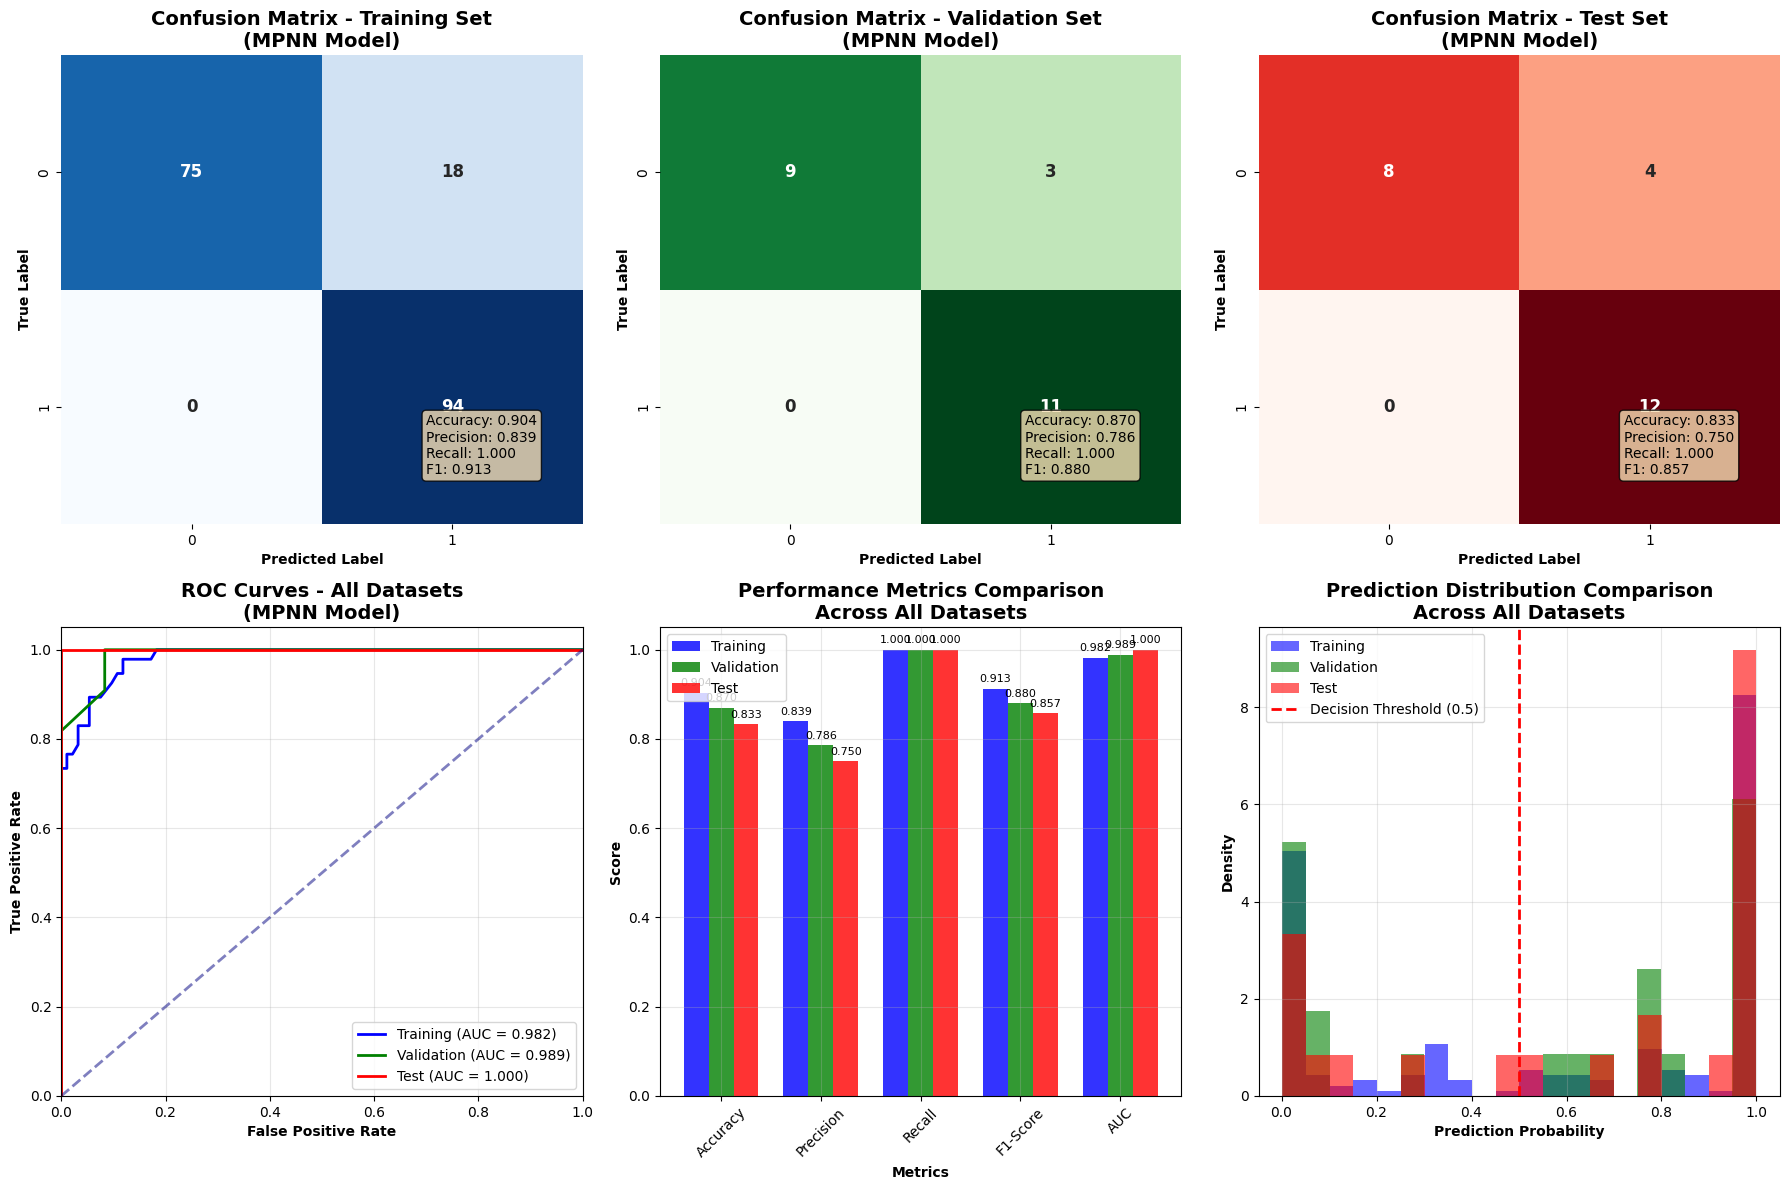


DETAILED PERFORMANCE METRICS FOR ALL DATASETS
   Dataset  Accuracy  Precision  Recall  F1-Score  AUC-ROC
  Training    0.9037     0.8393  1.0000    0.9126   0.9818
Validation    0.8696     0.7857  1.0000    0.8800   0.9886
      Test    0.8333     0.7500  1.0000    0.8571   1.0000

ADDITIONAL STATISTICS

TRAIN SET:
  Total samples: 187
  Positive samples: 94.0
  Negative samples: 93.0
  Positive prediction rate: 0.599
  True Positives: 94
  True Negatives: 75
  False Positives: 18
  False Negatives: 0
  Specificity: 0.806
  Negative Predictive Value: 1.000

VAL SET:
  Total samples: 23
  Positive samples: 11.0
  Negative samples: 12.0
  Positive prediction rate: 0.609
  True Positives: 11
  True Negatives: 9
  False Positives: 3
  False Negatives: 0
  Specificity: 0.750
  Negative Predictive Value: 1.000

TEST SET:
  Total samples: 24
  Positive samples: 12.0
  Negative samples: 12.0
  Positive prediction rate: 0.667
  True Positives: 12
  True Negatives: 8
  False Positives: 4
  Fals

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Performance metrics saved to 'mpnn_performance_metrics.csv'


In [25]:
# Generate Comprehensive Evaluation Plots for Train, Validation, and Test Sets

print("Generating comprehensive evaluation plots...")

# Function to evaluate model on all datasets
def evaluate_all_datasets(model, train_loader, val_loader, test_loader):
    results = {}

    # Evaluate on training set
    train_preds, train_probs, train_labels = evaluate_model(model, train_loader)
    results['train'] = {
        'preds': train_preds,
        'probs': train_probs,
        'labels': train_labels,
        'accuracy': accuracy_score(train_labels, train_preds),
        'precision': precision_score(train_labels, train_preds),
        'recall': recall_score(train_labels, train_preds),
        'f1': f1_score(train_labels, train_preds),
        'auc': roc_auc_score(train_labels, train_probs)
    }

    # Evaluate on validation set
    val_preds, val_probs, val_labels = evaluate_model(model, val_loader)
    results['val'] = {
        'preds': val_preds,
        'probs': val_probs,
        'labels': val_labels,
        'accuracy': accuracy_score(val_labels, val_preds),
        'precision': precision_score(val_labels, val_preds),
        'recall': recall_score(val_labels, val_preds),
        'f1': f1_score(val_labels, val_preds),
        'auc': roc_auc_score(val_labels, val_probs)
    }

    # Evaluate on test set
    test_preds, test_probs, test_labels = evaluate_model(model, test_loader)
    results['test'] = {
        'preds': test_preds,
        'probs': test_probs,
        'labels': test_labels,
        'accuracy': accuracy_score(test_labels, test_preds),
        'precision': precision_score(test_labels, test_preds),
        'recall': recall_score(test_labels, test_preds),
        'f1': f1_score(test_labels, test_preds),
        'auc': roc_auc_score(test_labels, test_probs)
    }

    return results

# Evaluate on all datasets
print("Evaluating model on all datasets...")
all_results = evaluate_all_datasets(model, train_loader, val_loader, test_loader)

# Create comprehensive plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Colors for different datasets
colors = {'train': 'blue', 'val': 'green', 'test': 'red'}

# 1. Confusion Matrix - Training Set
cm_train = confusion_matrix(all_results['train']['labels'], all_results['train']['preds'])
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0,0], cbar=False,
            annot_kws={'size': 12, 'weight': 'bold'})
axes[0,0].set_title('Confusion Matrix - Training Set\n(MPNN Model)', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Predicted Label', fontweight='bold')
axes[0,0].set_ylabel('True Label', fontweight='bold')

# Add performance metrics to confusion matrix
train_text = f"Accuracy: {all_results['train']['accuracy']:.3f}\nPrecision: {all_results['train']['precision']:.3f}\nRecall: {all_results['train']['recall']:.3f}\nF1: {all_results['train']['f1']:.3f}"
axes[0,0].text(0.7, 0.1, train_text, transform=axes[0,0].transAxes, fontsize=10,
               verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 2. Confusion Matrix - Validation Set
cm_val = confusion_matrix(all_results['val']['labels'], all_results['val']['preds'])
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens', ax=axes[0,1], cbar=False,
            annot_kws={'size': 12, 'weight': 'bold'})
axes[0,1].set_title('Confusion Matrix - Validation Set\n(MPNN Model)', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Predicted Label', fontweight='bold')
axes[0,1].set_ylabel('True Label', fontweight='bold')

val_text = f"Accuracy: {all_results['val']['accuracy']:.3f}\nPrecision: {all_results['val']['precision']:.3f}\nRecall: {all_results['val']['recall']:.3f}\nF1: {all_results['val']['f1']:.3f}"
axes[0,1].text(0.7, 0.1, val_text, transform=axes[0,1].transAxes, fontsize=10,
               verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 3. Confusion Matrix - Test Set
cm_test = confusion_matrix(all_results['test']['labels'], all_results['test']['preds'])
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds', ax=axes[0,2], cbar=False,
            annot_kws={'size': 12, 'weight': 'bold'})
axes[0,2].set_title('Confusion Matrix - Test Set\n(MPNN Model)', fontsize=14, fontweight='bold')
axes[0,2].set_xlabel('Predicted Label', fontweight='bold')
axes[0,2].set_ylabel('True Label', fontweight='bold')

test_text = f"Accuracy: {all_results['test']['accuracy']:.3f}\nPrecision: {all_results['test']['precision']:.3f}\nRecall: {all_results['test']['recall']:.3f}\nF1: {all_results['test']['f1']:.3f}"
axes[0,2].text(0.7, 0.1, test_text, transform=axes[0,2].transAxes, fontsize=10,
               verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 4. ROC Curves - All Datasets
# Training set ROC
fpr_train, tpr_train, _ = roc_curve(all_results['train']['labels'], all_results['train']['probs'])
roc_auc_train = auc(fpr_train, tpr_train)

# Validation set ROC
fpr_val, tpr_val, _ = roc_curve(all_results['val']['labels'], all_results['val']['probs'])
roc_auc_val = auc(fpr_val, tpr_val)

# Test set ROC
fpr_test, tpr_test, _ = roc_curve(all_results['test']['labels'], all_results['test']['probs'])
roc_auc_test = auc(fpr_test, tpr_test)

# Plot all ROC curves
axes[1,0].plot(fpr_train, tpr_train, color=colors['train'], lw=2,
               label=f'Training (AUC = {roc_auc_train:.3f})')
axes[1,0].plot(fpr_val, tpr_val, color=colors['val'], lw=2,
               label=f'Validation (AUC = {roc_auc_val:.3f})')
axes[1,0].plot(fpr_test, tpr_test, color=colors['test'], lw=2,
               label=f'Test (AUC = {roc_auc_test:.3f})')
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
axes[1,0].set_xlim([0.0, 1.0])
axes[1,0].set_ylim([0.0, 1.05])
axes[1,0].set_xlabel('False Positive Rate', fontweight='bold')
axes[1,0].set_ylabel('True Positive Rate', fontweight='bold')
axes[1,0].set_title('ROC Curves - All Datasets\n(MPNN Model)', fontsize=14, fontweight='bold')
axes[1,0].legend(loc="lower right")
axes[1,0].grid(True, alpha=0.3)

# 5. Performance Metrics Comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
train_metrics = [all_results['train']['accuracy'], all_results['train']['precision'],
                all_results['train']['recall'], all_results['train']['f1'], all_results['train']['auc']]
val_metrics = [all_results['val']['accuracy'], all_results['val']['precision'],
              all_results['val']['recall'], all_results['val']['f1'], all_results['val']['auc']]
test_metrics = [all_results['test']['accuracy'], all_results['test']['precision'],
               all_results['test']['recall'], all_results['test']['f1'], all_results['test']['auc']]

x_pos = np.arange(len(metrics))
width = 0.25

axes[1,1].bar(x_pos - width, train_metrics, width, label='Training', color=colors['train'], alpha=0.8)
axes[1,1].bar(x_pos, val_metrics, width, label='Validation', color=colors['val'], alpha=0.8)
axes[1,1].bar(x_pos + width, test_metrics, width, label='Test', color=colors['test'], alpha=0.8)

axes[1,1].set_xlabel('Metrics', fontweight='bold')
axes[1,1].set_ylabel('Score', fontweight='bold')
axes[1,1].set_title('Performance Metrics Comparison\nAcross All Datasets', fontsize=14, fontweight='bold')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels(metrics, rotation=45)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(train_metrics):
    axes[1,1].text(i - width, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)
for i, v in enumerate(val_metrics):
    axes[1,1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)
for i, v in enumerate(test_metrics):
    axes[1,1].text(i + width, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

# 6. Prediction Distribution Comparison
axes[1,2].hist(all_results['train']['probs'], bins=20, alpha=0.6, color=colors['train'],
               label='Training', density=True)
axes[1,2].hist(all_results['val']['probs'], bins=20, alpha=0.6, color=colors['val'],
               label='Validation', density=True)
axes[1,2].hist(all_results['test']['probs'], bins=20, alpha=0.6, color=colors['test'],
               label='Test', density=True)
axes[1,2].axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold (0.5)', linewidth=2)
axes[1,2].set_xlabel('Prediction Probability', fontweight='bold')
axes[1,2].set_ylabel('Density', fontweight='bold')
axes[1,2].set_title('Prediction Distribution Comparison\nAcross All Datasets', fontsize=14, fontweight='bold')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed performance table
print("\n" + "="*80)
print("DETAILED PERFORMANCE METRICS FOR ALL DATASETS")
print("="*80)

performance_table = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Test'],
    'Accuracy': [all_results['train']['accuracy'], all_results['val']['accuracy'], all_results['test']['accuracy']],
    'Precision': [all_results['train']['precision'], all_results['val']['precision'], all_results['test']['precision']],
    'Recall': [all_results['train']['recall'], all_results['val']['recall'], all_results['test']['recall']],
    'F1-Score': [all_results['train']['f1'], all_results['val']['f1'], all_results['test']['f1']],
    'AUC-ROC': [all_results['train']['auc'], all_results['val']['auc'], all_results['test']['auc']]
})

print(performance_table.to_string(index=False, float_format='%.4f'))

# Additional detailed statistics
print("\n" + "="*80)
print("ADDITIONAL STATISTICS")
print("="*80)

for dataset_name, results in all_results.items():
    print(f"\n{dataset_name.upper()} SET:")
    print(f"  Total samples: {len(results['labels'])}")
    print(f"  Positive samples: {sum(results['labels'])}")
    print(f"  Negative samples: {len(results['labels']) - sum(results['labels'])}")
    print(f"  Positive prediction rate: {sum(results['preds']) / len(results['preds']):.3f}")

    # Calculate additional metrics
    tn, fp, fn, tp = confusion_matrix(results['labels'], results['preds']).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    print(f"  True Positives: {tp}")
    print(f"  True Negatives: {tn}")
    print(f"  False Positives: {fp}")
    print(f"  False Negatives: {fn}")
    print(f"  Specificity: {specificity:.3f}")
    print(f"  Negative Predictive Value: {npv:.3f}")

# Save the performance results to CSV
performance_table.to_csv('mpnn_performance_metrics.csv', index=False)
files.download('mpnn_performance_metrics.csv')
print("\nPerformance metrics saved to 'mpnn_performance_metrics.csv'")

Generating individual ROC curves with detailed analysis...


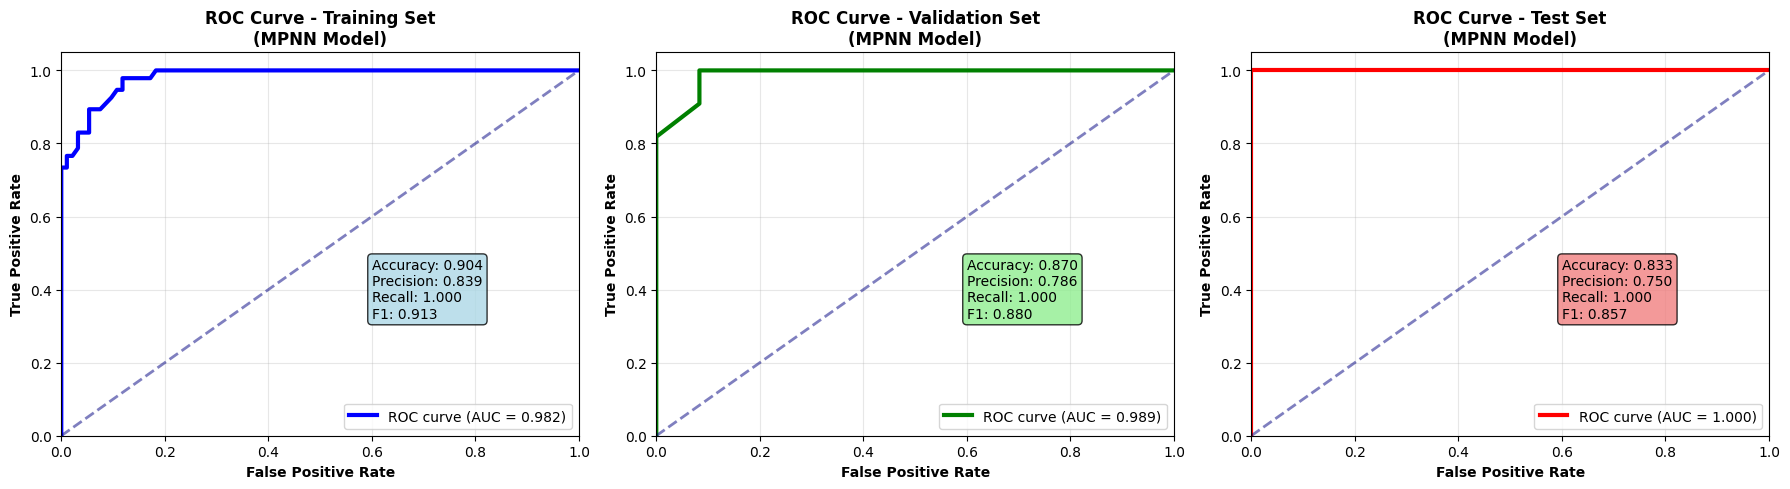


OPTIMAL THRESHOLDS ANALYSIS
Training Set:
  Optimal threshold: 0.622
  Youden's J statistic: 0.860

Validation Set:
  Optimal threshold: 0.676
  Youden's J statistic: 0.917

Test Set:
  Optimal threshold: 0.918
  Youden's J statistic: 1.000

PERFORMANCE AT OPTIMAL THRESHOLDS
   Dataset  Optimal Threshold  Accuracy  Precision  Recall  F1-Score
  Training             0.6217    0.9305     0.8932  0.9787    0.9340
Validation             0.6762    0.9565     0.9167  1.0000    0.9565
      Test             0.9184    1.0000     1.0000  1.0000    1.0000


In [26]:
# Additional: Individual ROC Curves with Detailed Analysis

print("Generating individual ROC curves with detailed analysis...")

# Create individual ROC plots for each dataset
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training set ROC with detailed analysis
fpr_train, tpr_train, thresholds_train = roc_curve(all_results['train']['labels'], all_results['train']['probs'])
roc_auc_train = auc(fpr_train, tpr_train)

axes[0].plot(fpr_train, tpr_train, color='blue', lw=3, label=f'ROC curve (AUC = {roc_auc_train:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontweight='bold')
axes[0].set_title('ROC Curve - Training Set\n(MPNN Model)', fontsize=12, fontweight='bold')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Add performance details
train_details = f"Accuracy: {all_results['train']['accuracy']:.3f}\nPrecision: {all_results['train']['precision']:.3f}\nRecall: {all_results['train']['recall']:.3f}\nF1: {all_results['train']['f1']:.3f}"
axes[0].text(0.6, 0.3, train_details, transform=axes[0].transAxes, fontsize=10,
             verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Validation set ROC
fpr_val, tpr_val, thresholds_val = roc_curve(all_results['val']['labels'], all_results['val']['probs'])
roc_auc_val = auc(fpr_val, tpr_val)

axes[1].plot(fpr_val, tpr_val, color='green', lw=3, label=f'ROC curve (AUC = {roc_auc_val:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontweight='bold')
axes[1].set_title('ROC Curve - Validation Set\n(MPNN Model)', fontsize=12, fontweight='bold')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

val_details = f"Accuracy: {all_results['val']['accuracy']:.3f}\nPrecision: {all_results['val']['precision']:.3f}\nRecall: {all_results['val']['recall']:.3f}\nF1: {all_results['val']['f1']:.3f}"
axes[1].text(0.6, 0.3, val_details, transform=axes[1].transAxes, fontsize=10,
             verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# Test set ROC
fpr_test, tpr_test, thresholds_test = roc_curve(all_results['test']['labels'], all_results['test']['probs'])
roc_auc_test = auc(fpr_test, tpr_test)

axes[2].plot(fpr_test, tpr_test, color='red', lw=3, label=f'ROC curve (AUC = {roc_auc_test:.3f})')
axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate', fontweight='bold')
axes[2].set_ylabel('True Positive Rate', fontweight='bold')
axes[2].set_title('ROC Curve - Test Set\n(MPNN Model)', fontsize=12, fontweight='bold')
axes[2].legend(loc="lower right")
axes[2].grid(True, alpha=0.3)

test_details = f"Accuracy: {all_results['test']['accuracy']:.3f}\nPrecision: {all_results['test']['precision']:.3f}\nRecall: {all_results['test']['recall']:.3f}\nF1: {all_results['test']['f1']:.3f}"
axes[2].text(0.6, 0.3, test_details, transform=axes[2].transAxes, fontsize=10,
             verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

plt.tight_layout()
plt.show()

# Print optimal thresholds for each dataset
print("\n" + "="*60)
print("OPTIMAL THRESHOLDS ANALYSIS")
print("="*60)

def find_optimal_threshold(fpr, tpr, thresholds):
    """Find optimal threshold using Youden's J statistic"""
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    return thresholds[optimal_idx], youden_j[optimal_idx]

optimal_threshold_train, youden_j_train = find_optimal_threshold(fpr_train, tpr_train, thresholds_train)
optimal_threshold_val, youden_j_val = find_optimal_threshold(fpr_val, tpr_val, thresholds_val)
optimal_threshold_test, youden_j_test = find_optimal_threshold(fpr_test, tpr_test, thresholds_test)

print(f"Training Set:")
print(f"  Optimal threshold: {optimal_threshold_train:.3f}")
print(f"  Youden's J statistic: {youden_j_train:.3f}")

print(f"\nValidation Set:")
print(f"  Optimal threshold: {optimal_threshold_val:.3f}")
print(f"  Youden's J statistic: {youden_j_val:.3f}")

print(f"\nTest Set:")
print(f"  Optimal threshold: {optimal_threshold_test:.3f}")
print(f"  Youden's J statistic: {youden_j_test:.3f}")

# Performance at optimal threshold
def evaluate_at_threshold(probs, labels, threshold):
    preds = (probs >= threshold).astype(int)
    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds),
        'recall': recall_score(labels, preds),
        'f1': f1_score(labels, preds)
    }

print("\n" + "="*60)
print("PERFORMANCE AT OPTIMAL THRESHOLDS")
print("="*60)

optimal_perf_train = evaluate_at_threshold(all_results['train']['probs'], all_results['train']['labels'], optimal_threshold_train)
optimal_perf_val = evaluate_at_threshold(all_results['val']['probs'], all_results['val']['labels'], optimal_threshold_val)
optimal_perf_test = evaluate_at_threshold(all_results['test']['probs'], all_results['test']['labels'], optimal_threshold_test)

optimal_perf_table = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Test'],
    'Optimal Threshold': [optimal_threshold_train, optimal_threshold_val, optimal_threshold_test],
    'Accuracy': [optimal_perf_train['accuracy'], optimal_perf_val['accuracy'], optimal_perf_test['accuracy']],
    'Precision': [optimal_perf_train['precision'], optimal_perf_val['precision'], optimal_perf_test['precision']],
    'Recall': [optimal_perf_train['recall'], optimal_perf_val['recall'], optimal_perf_test['recall']],
    'F1-Score': [optimal_perf_train['f1'], optimal_perf_val['f1'], optimal_perf_test['f1']]
})

print(optimal_perf_table.to_string(index=False, float_format='%.4f'))